# Principal Component Analysis

In this notebook, we will describe the implementation of the Principal Component Analysis (PCA) algorithm. We'll use this algorithm to explore daily changes in the close prices for 21 technology stocks.

In [ ]:
#!pip install mpl-axes-aligner
#!pip install yfinance

In [1]:
## imports ##
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
import statsmodels.api as sm
import scipy.stats as stats
import mpl_axes_aligner
from typing import Dict,Tuple

Implement a class that encapsulates the PCA algorithm:

In [2]:
## classes ##

#class that encapsulates the PCA model
class PCA(object):
    #initialiser function
    def __init__(self,n_components : int = 0) -> None:
        self.n_components = n_components
        self.e_val        = np.array([])
        self.e_vec        = np.array([])
        self.col_idx      = np.array([])
        
    #destructor
    def __del__(self) -> None:
        del self.n_components
        del self.e_val
        del self.e_vec
        del self.col_idx
    
    #public function to train the model
    def fit(self, X_train : np.array) -> None:
        #since I'm assuming the input matrix X_train has shape (samples,features), compute the transpose
        X = np.transpose(X_train)
        #remove the mean from each feature
        X -= np.mean(X,axis=1).reshape(-1,1)
        #compute the covariance matrix of X
        C = np.matmul(X,np.transpose(X))
        #find the eigenvalues & eigenvectors of the covariance
        self.e_val,self.e_vec = np.linalg.eig(C)
        #sort the negated eigenvalues (to get sort in decending order)
        self.col_idx = np.argsort(-self.e_val)
        
    #public function to transform the dataset
    def transform(self, X) -> np.array:
        #check that the model has been trained?
        if self.e_val.size and self.e_vec.size and self.col_idx.size:
            #since I'm assuming the input matrix X_train has shape (samples,features), compute the transpose
            X = np.transpose(X)
            #project data onto the PCs
            X_new = np.matmul(np.transpose(self.e_vec),X)
            #transform back via tranpose + sort by variance explained
            X_new = np.transpose(X_new)
            X_new = X_new[:,self.col_idx]
            #if n_components was specified, return only this number of features back
            if self.n_components != 0:
                X_new = X_new[:,:self.n_components]
            #return
            return(X_new)
        else:
            print('Empty eigenvectors and eigenvalues, did you forget to train the model?')
            return(np.array([]))
        
    #public function to return % explained variance per PC
    def explained_variance_ratio(self) -> np.array:
        #check that the model has been trained?
        if self.e_val.size and self.col_idx.size:
            #compute the sorted % explained variances 
            perc = self.e_val[self.col_idx]
            perc = perc/np.sum(perc)
            #if n_components was specified, return only this number of features back
            if self.n_components != 0:
                perc = perc[:self.n_components]
            #return
            return(perc)
        else:
            print('Empty eigenvalues, did you forget to train the model?')
            return(np.array([]))
        
    #public function to return the eigenvalues & eigenvectors
    def return_eigen_vectors_values(self) -> Tuple[np.array,np.array]:
        #check that the model has been trained?
        if self.e_val.size and self.e_vec.size and self.col_idx.size:
            #sort the eigenvalues and eigenvectors
            e_val = self.e_val[self.col_idx]
            e_vec = self.e_vec[:,self.col_idx]
            #if n_components was specified, return only this number of features back
            if self.n_components != 0:
                e_val = e_val[:self.n_components]
                e_vec = e_vec[:,:self.n_components]
            #return
            return(e_vec,e_val)
        else:
            print('Empty eigenvalues & eigenvectors, did you forget to train the model?')
            return(np.array([]),np.array([]))

In [3]:
## functions ##

#function to produce biplot
def biplot(dfScores: pd.DataFrame, dfLoadings: pd.DataFrame) -> None:
    
    #create figure and axis objects
    fig,ax = plt.subplots(figsize=(15,8))
    
    #make a scores plot
    ax.scatter(dfScores.PC1.values,dfScores.PC2.values, color='b')
    #set x-axis label
    ax.set_xlabel("PC1",fontsize=10)
    #set y-axis label
    ax.set_ylabel("PC2",fontsize=10)
    
    #create a second set of axes
    ax2 = ax.twinx().twiny()
    
    #make a loadings plot
    for col in dfLoadings.columns.values:
        #where do our loading vectors end?
        tipx = dfLoadings.loc['PC1',col]
        tipy = dfLoadings.loc['PC2',col]
        #draw the vector, and write label text for col
        ax2.arrow(0, 0, tipx, tipy, color = 'r', alpha = 0.5)
        ax2.text(tipx*1.05, tipy*1.05, col, color = 'g', ha = 'center', va = 'center')
    
    #align x = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.xaxes(ax, 0, ax2, 0, 0.5)
    #align y = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.yaxes(ax, 0, ax2, 0, 0.5)
    
    #show plot
    plt.show()
    
#Function to check  whether the point (x,y) is outside the ellipse defined by (u,v,a,b)
def outside_ellipse(x, y, u, v, a, b):
 
    #checking the equation of ellipse with the given point
    p = ((x-u)/a)**2 + ((y-v)/b)**2 
        
    #convert output to boolean (True if outside the ellipse)
    p = p > 1

    return(p)

## Load Trading Data

I will use the yfinance package to load daily stock data from yahoo finance. This data will be used to train the PCA model:

In [4]:
#read in data from yahoo
stocks = "AAPL MSFT AMZN FB GOOG NVDA FIS AMD TDC HUBS FTNT ASML INTC IBM ORCL CSCO " \
         "SONY HTHIY TCEHY PCRFY LNVGY"
dfData = yf.download(stocks, start="2015-01-01", end="2021-10-01")

[*********************100%***********************]  21 of 21 completed


## Preprocessing

Here I will prepare the raw data into something we can work with. Namely:

1. Isolate the adjusted close prices only
2. Calculate the daily percent changes, and remove NaN values
3. Scale the data, so that each feature has a mean of 0 and a standard deviation of 1

In [5]:
#extract out adjusted close prices
dfClose = dfData['Adj Close'].copy()

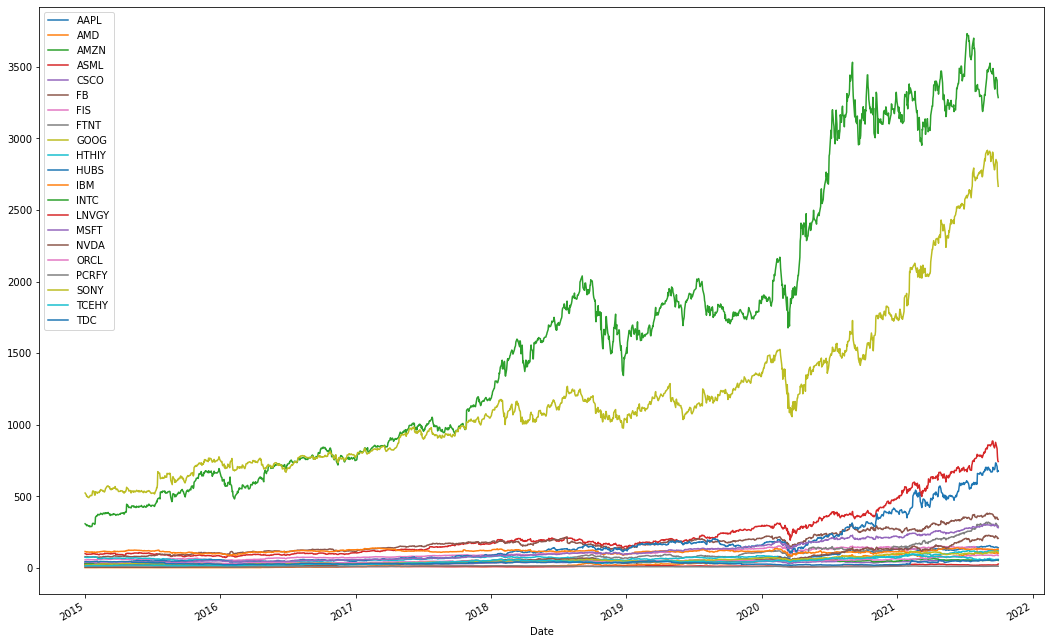

In [6]:
#plot the adjusted close prices
dfClose.plot(figsize=(18,12))
plt.show()

In [7]:
#compute differences in close prices
dfClose = dfClose.pct_change().dropna()

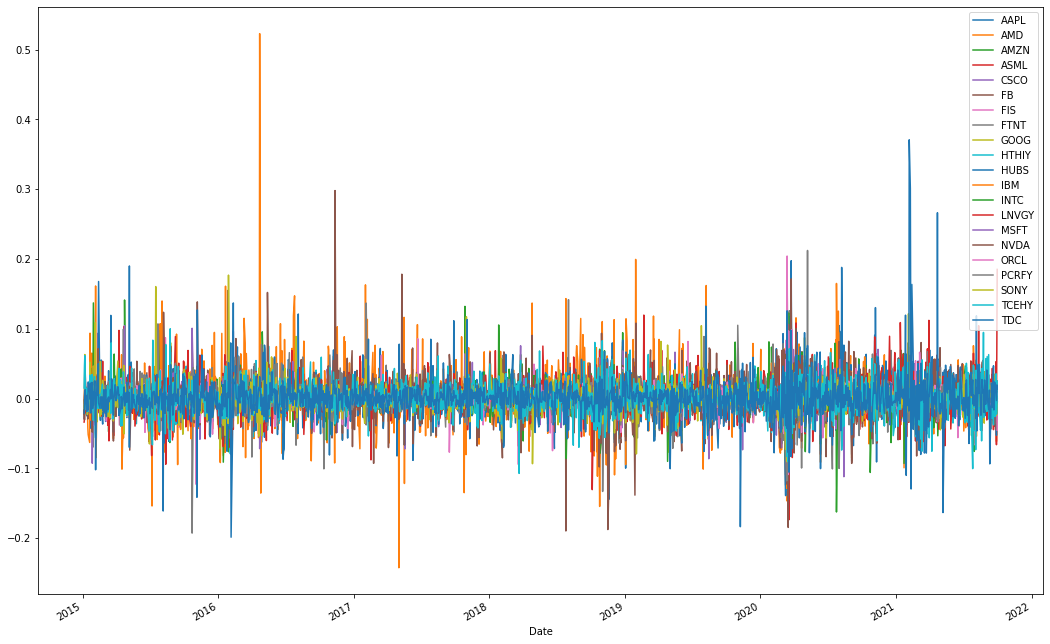

In [8]:
#plot the differenced close prices
dfClose.plot(figsize=(18,12))
plt.show()

In [9]:
#standarise data set
scaler = StandardScaler()
closes = scaler.fit_transform(dfClose)
dfClose = pd.DataFrame(closes,columns=dfClose.columns)

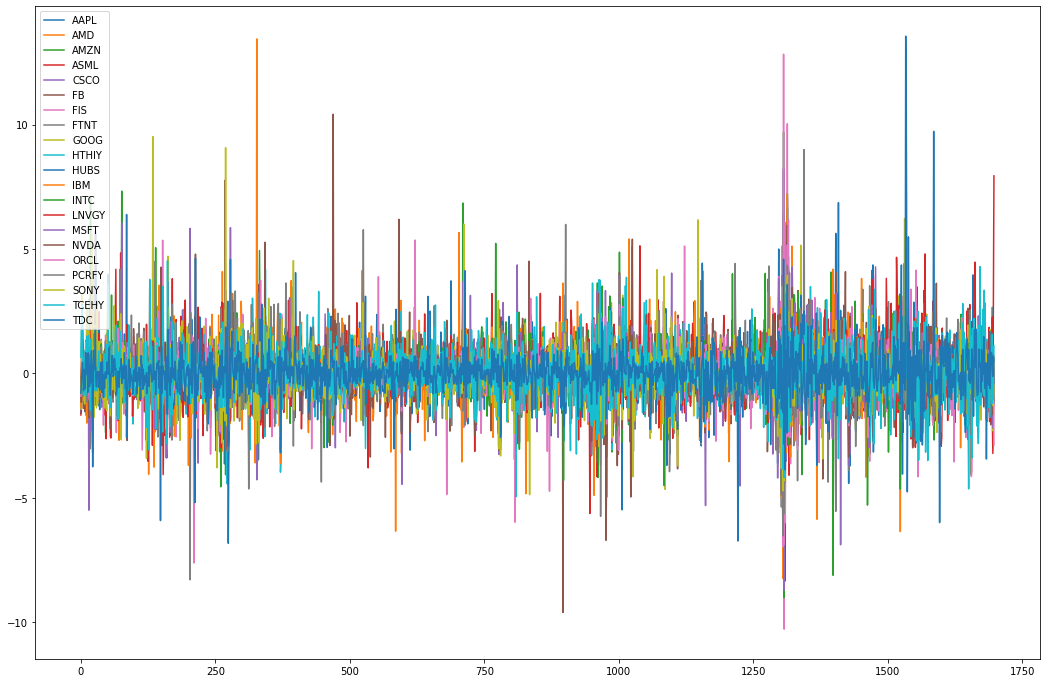

In [10]:
#plot the standised close price differences
dfClose.plot(figsize=(18,12))
plt.show()

## Checking Assumptions: Quantile - Quantile Plots

Question: do our preprocessed stocks appear to follow a normal distribution?

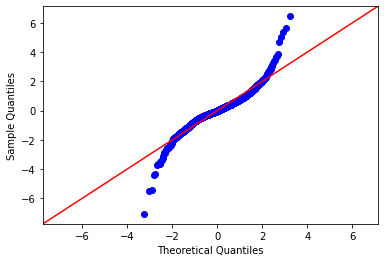

In [11]:
#create Q-Q plot with 45-degree line added to plot AAPL
fig = sm.qqplot(dfClose.AAPL.values, dist=stats.norm, loc=0, scale=1, line='45')
plt.show()

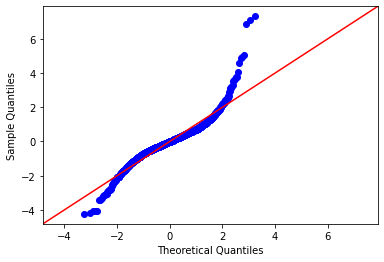

In [12]:
#create Q-Q plot with 45-degree line added to plot AMZN
fig = sm.qqplot(dfClose.AMZN.values, dist=stats.norm, loc=0, scale=1, line='45')
plt.show()

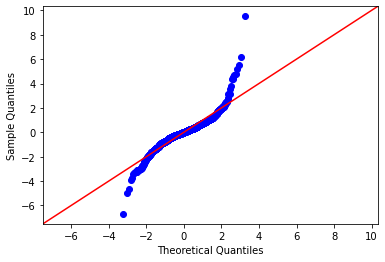

In [13]:
#create Q-Q plot with 45-degree line added to plot GOOG
fig = sm.qqplot(dfClose.GOOG.values, dist=stats.norm, loc=0, scale=1, line='45')
plt.show()

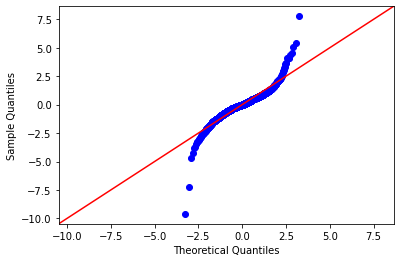

In [14]:
#create Q-Q plot with 45-degree line added to plot FB
fig = sm.qqplot(dfClose.FB.values, dist=stats.norm, loc=0, scale=1, line='45')
plt.show()

Looking at this subset of stocks, we can see that there are large deviations from a normal distribution in the tails of our data distributions. This is indicative of "fat tails", with respect to a normal distribution. Despite this limitation, we will continue with our analysis. 

## PCA - Training

Let's begin with our custom PCA model. We'll fit this to our processed close prices:

In [15]:
#fit the PCA model and transform the data
pca_custom = PCA()
pca_custom.fit(closes)
pcs        = pca_custom.transform(closes)
dfPCs1     = pd.DataFrame(pcs,columns=['PC'+str(i) for i in range(1,dfClose.shape[1]+1)])

In [16]:
#take a look at the transformed data
dfPCs1.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,-3.726660,-0.240796,-0.536629,0.460018,0.450910,0.043861,0.222354,-0.197132,0.342378,0.676830,...,0.242861,0.128569,0.105043,-0.184834,-0.602788,0.227862,-0.735126,0.659417,0.493244,0.712111
1,-2.776552,0.299463,-1.299268,0.312300,-1.051665,0.127871,-0.059622,-0.071302,1.362753,1.571670,...,-0.651293,0.475215,0.448563,0.801455,0.446269,-0.246935,-1.005952,0.097381,-0.001559,0.141351
2,2.507308,1.098365,-2.460828,-0.365647,-1.198310,0.474974,-0.065488,-0.134265,2.656003,1.160297,...,-0.619203,0.734792,-0.511061,0.459127,-0.173385,0.859317,-0.629614,0.408384,-0.330345,0.020087
3,3.873381,0.096586,-0.629685,0.100231,-1.060157,-0.236307,0.779930,-0.288457,-0.349563,-0.416763,...,-0.331546,-0.371540,0.047688,0.370311,0.807914,-0.982827,-0.086328,0.977563,-0.318055,0.968334
4,-1.297565,0.023470,1.206957,0.706146,-0.223413,-0.610784,-0.220840,0.000441,0.243128,-0.097005,...,-0.185383,0.278777,-0.212169,0.024731,0.162041,-0.360043,-0.677267,-0.026281,-0.164205,-0.060206


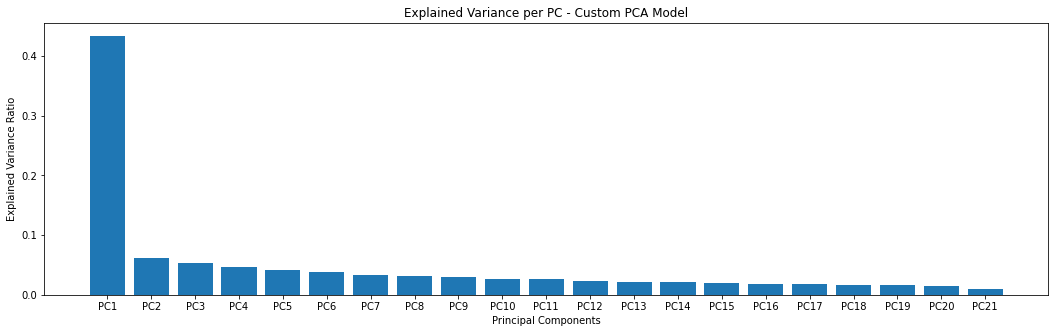

In [17]:
#how much variance is explained by each pc?
f, ax = plt.subplots(figsize=(18,5))
plt.bar(['PC'+str(i) for i in range(1,22)],pca_custom.explained_variance_ratio())
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance per PC - Custom PCA Model')
plt.show()

This looks good! I now want to train the PCA model available from scikit-learn, and compare the results:

In [18]:
#import scikit-learn PCA
from sklearn.decomposition import PCA

In [19]:
#fit the PCA model and transform the data
pca    = PCA()
pcs    = pca.fit_transform(closes)
dfPCs2 = pd.DataFrame(pcs,columns=['PC'+str(i) for i in range(1,dfClose.shape[1]+1)])

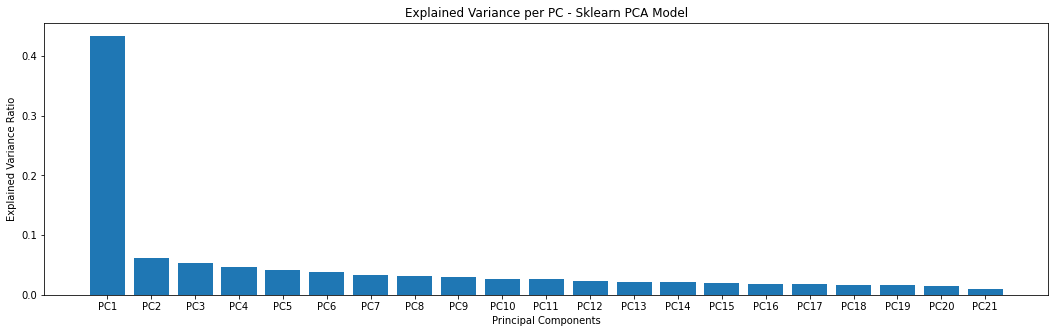

In [20]:
#how much variance is explained by each pc?
f, ax = plt.subplots(figsize=(18,5))
plt.bar(['PC'+str(i) for i in range(1,22)],pca.explained_variance_ratio_)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance per PC - Sklearn PCA Model')
plt.show()

In [21]:
#what does the transformed data look like?
dfPCs2.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,3.726660,-0.240796,-0.536629,0.460018,-0.450910,0.043861,-0.222354,-0.197132,0.342378,-0.676830,...,0.242861,-0.128569,0.105043,-0.184834,0.602788,-0.227862,0.735126,0.659417,0.493244,-0.712111
1,2.776552,0.299463,-1.299268,0.312300,1.051665,0.127871,0.059622,-0.071302,1.362753,-1.571670,...,-0.651293,-0.475215,0.448563,0.801455,-0.446269,0.246935,1.005952,0.097381,-0.001559,-0.141351
2,-2.507308,1.098365,-2.460828,-0.365647,1.198310,0.474974,0.065488,-0.134265,2.656003,-1.160297,...,-0.619203,-0.734792,-0.511061,0.459127,0.173385,-0.859317,0.629614,0.408384,-0.330345,-0.020087
3,-3.873381,0.096586,-0.629685,0.100231,1.060157,-0.236307,-0.779930,-0.288457,-0.349563,0.416763,...,-0.331546,0.371540,0.047688,0.370311,-0.807914,0.982827,0.086328,0.977563,-0.318055,-0.968334
4,1.297565,0.023470,1.206957,0.706146,0.223413,-0.610784,0.220840,0.000441,0.243128,0.097005,...,-0.185383,-0.278777,-0.212169,0.024731,-0.162041,0.360043,0.677267,-0.026281,-0.164205,0.060206


The transformed data looks to have the same absolute values as when we used the custom model. However, for some of the entries the sign is flipped. Let's check this more throughly:

In [22]:
#check if our two outputs are equal?
np.allclose(dfPCs1,dfPCs2)

False

In [23]:
#... ok what if we just compare the absolute values?
np.allclose(np.absolute(dfPCs1),np.absolute(dfPCs2))

True

These checks confirm our suspicions: some of the values in our transformed data have their signs flipped between the two PCA models. The solutions are actually equivalent, since in the scikit-learn model PCA is done using SVD, and both signed versions of the eignvectors form a valid solution. See the discussion here for more details: https://stackoverflow.com/questions/44765682/in-sklearn-decomposition-pca-why-are-components-negative

At this point, we can also extract the eigenvectors from the trained model:

In [24]:
#extract out our eigenvectors from the trained model
dfLoadings = pd.DataFrame(pca.components_,columns=dfClose.columns,index=dfPCs2.columns)

## PCA - Results

Now we can take a closer look at the results from PCA on the stock data at hand. Since the two models looked at before are equivalent, we could proceed with either. I will use the scikit-learn results below:

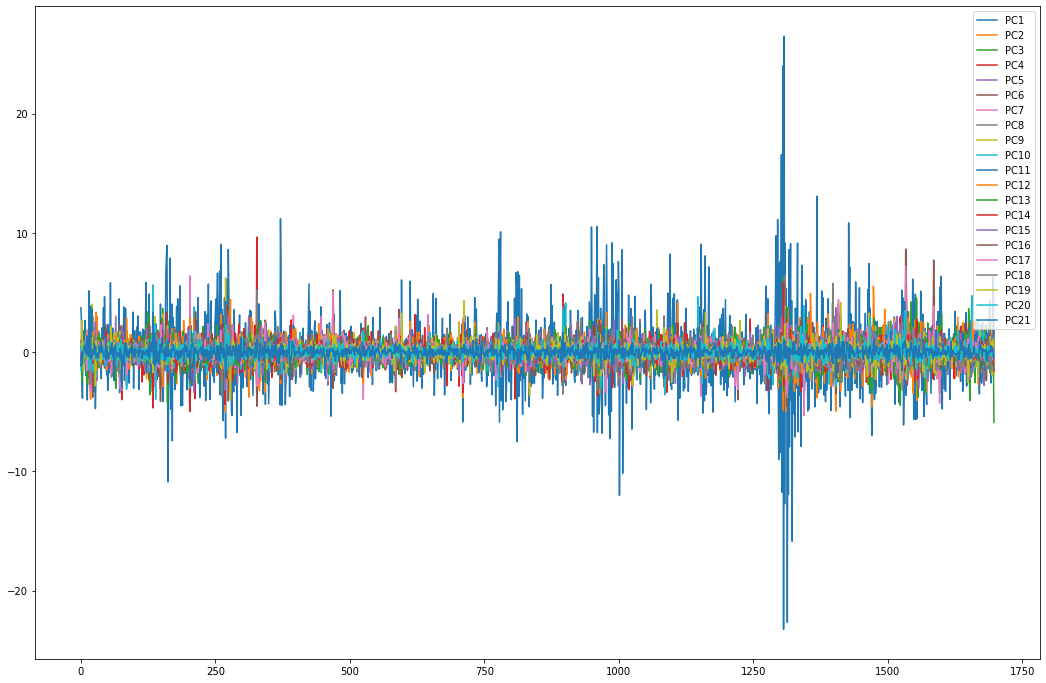

In [25]:
#plot the PC's in temporal space
dfPCs2.plot(figsize=(18,12))
plt.show()

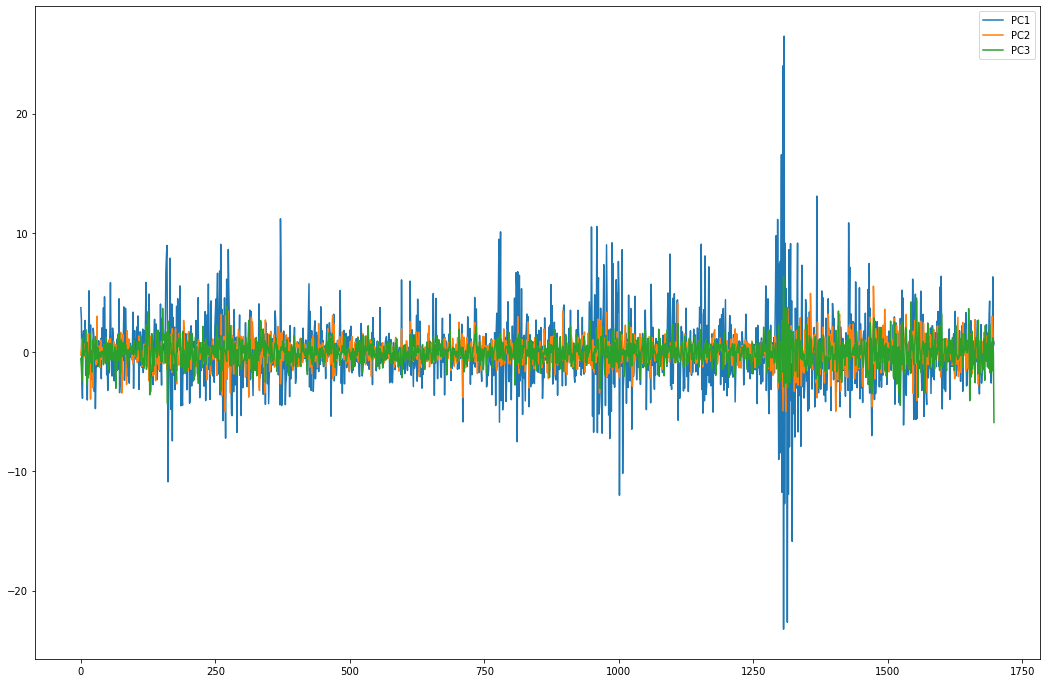

In [26]:
#plot just the first 3 PCs
dfPCs2[['PC1','PC2','PC3']].plot(figsize=(18,12))
plt.show()

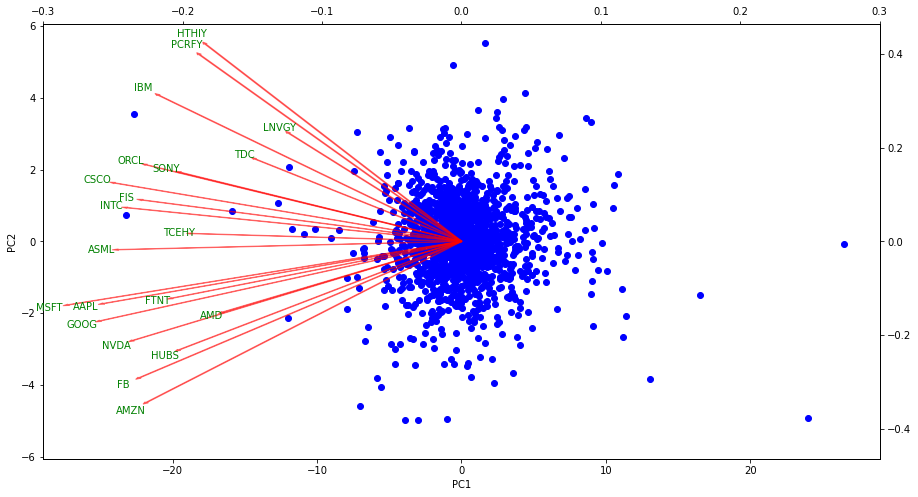

In [27]:
#produce biplot
biplot(dfPCs2, dfLoadings)

The biplot results show the distribution in the daily % change in the portfolio close prices projected onto the first two principal components. The loading vectors, for each of the constituent stocks, indicate how strongly each stock contributes to PC1 and PC2. Note that all the stocks contribute mainly to PC1. What is interesting are the correlations among stocks, illustrated by how closely the vectors are positioned together. The large US tech giants (AMZN, GOOG, FB, AAPL, MSFT) are clustered in the lower left of the figure. More mature companies (IBM, PCRFY, HTHIY, etc) are clustered in the upper left of the plot.

In [28]:
#isolate out just the first 2 principal components
dfPC12 = dfPCs2[['PC1','PC2']].copy()

#### Closer look at PC1

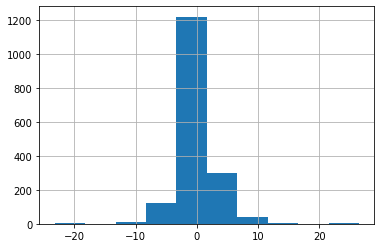

In [29]:
dfPC12.PC1.hist()
plt.show()

In [30]:
#0.5% and 99.5% percentiles
pc1_q = np.percentile(dfPC12.PC1.values,q=[0.5,99.5])
pc1_q

array([-9.60784353, 10.51759603])

In [31]:
#work out coordinates for PC1
u = np.mean(pc1_q)
a = pc1_q[1] - u

#### Closer look at PC2

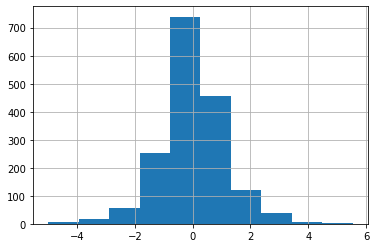

In [32]:
dfPC12.PC2.hist()
plt.show()

In [33]:
#0.5% and 99.5% percentiles
pc2_q = np.percentile(dfPC12.PC2.values,q=[0.5,99.5])
pc2_q

array([-3.79466198,  3.38275052])

In [34]:
#work out coordinates for PC2
v = np.mean(pc2_q)
b = pc2_q[1] - v

#### View the Data in PC space

A simple 2D plot that encompases the data projected onto the first 2 principal components (~49% of the variance in the data). The red ellipse is defined by the 0.5% and 99.5% percentiles in these principal components.

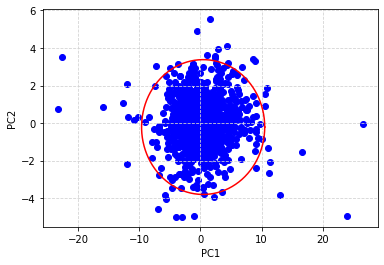

In [35]:
#draw 2D ellipse in PC space
t = np.linspace(0, 2*math.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t) , color='r' )
plt.grid(color='lightgray',linestyle='--')
plt.scatter(dfPC12.PC1.values,dfPC12.PC2.values, color='b')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### Look at the Outliers

In [36]:
#attach dates to the PC dataframe
dfPC12['Date'] = dfData.index.values[1:]

In [37]:
#attach boolean feature to flag outlier points 
dfPC12['Outlier'] = [outside_ellipse(x,y,u,v,a,b) for x,y in zip(dfPC12.PC1.values,dfPC12.PC2.values)]

In [38]:
#take a look at the resulting dataframe
dfPC12.head(5)

,PC1,PC2,Date,Outlier
0,3.726660,-0.240796,2015-01-05,False
1,2.776552,0.299463,2015-01-06,False
2,-2.507308,1.098365,2015-01-07,False
3,-3.873381,0.096586,2015-01-08,False
4,1.297565,0.023470,2015-01-09,False


In [39]:
#isolate out the outliers
dfOutliers = dfPC12[dfPC12.Outlier].copy()
dfOutliers.reset_index(inplace=True,drop=True)

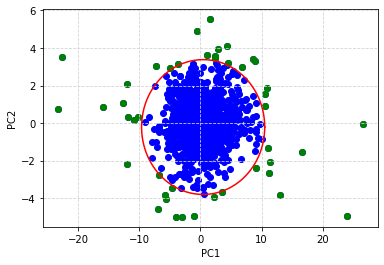

In [40]:
#draw 2D ellipse in PC space & show outliers
t = np.linspace(0, 2*math.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t) , color='r' )
plt.grid(color='lightgray',linestyle='--')
plt.scatter(dfPC12.PC1.values,dfPC12.PC2.values, color='b')
plt.scatter(dfOutliers.PC1.values,dfOutliers.PC2.values, color='g')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [41]:
#extract out adjusted close prices
dfClose = dfData['Adj Close'].copy()

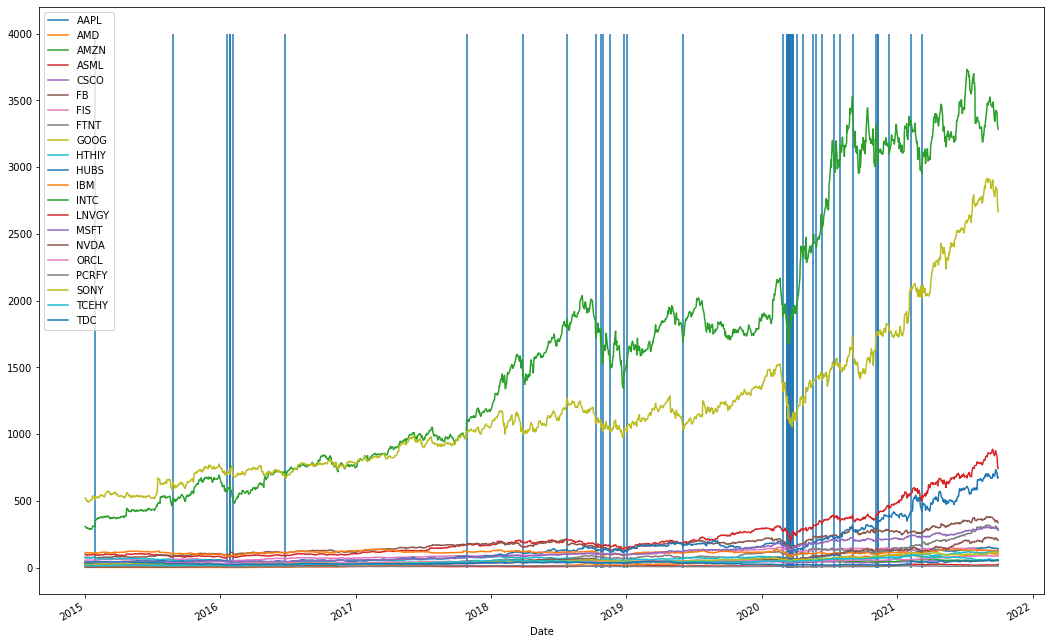

In [42]:
#visualise stock prices overlayed with outlier time points
dfClose.plot(figsize=(18,12))
plt.vlines(dfOutliers.Date,0,4000)
plt.show()

Interpret the above plot with: https://en.wikipedia.org/wiki/List_of_stock_market_crashes_and_bear_markets

There are three clusters of anomalys in the timeline, the first is centered around the beginning of 2016, and corresponds to the crash in the Chinese market of that year. The second cluster is centered towards the end of 2018, and is associated with cryptocurrency crash of that year. The third cluster is focused after the beginning of 2020, and correspond to the market downturns due to covid-19.

## PCA - Predictions

Let's now read in new data, transform it through the trained PCA model, and visualise the results.

In [43]:
#read in data from yahoo
stocks = "AAPL MSFT AMZN FB GOOG NVDA FIS AMD TDC HUBS FTNT ASML INTC IBM ORCL CSCO " \
         "SONY HTHIY TCEHY PCRFY LNVGY"
dfData = yf.download(stocks, start="2021-10-02", end="2021-11-18")

[*********************100%***********************]  21 of 21 completed


In [44]:
#extract out adjusted close prices
dfClose = dfData['Adj Close'].copy()

In [45]:
#compute differences in close prices
dfClose = dfClose.pct_change().dropna()

In [46]:
#standardise the dataset with the scaler already fitted
closes = scaler.transform(dfClose)

In [47]:
#transform data into PC space
pc = pca.transform(closes)

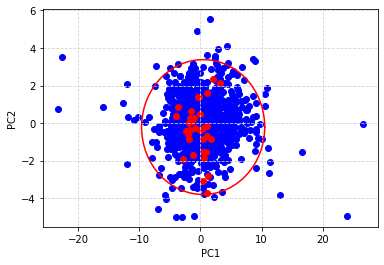

In [48]:
#draw 2D ellipse in PC space & show predictions
t = np.linspace(0, 2*math.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t) , color='r' )
plt.grid(color='lightgray',linestyle='--')
plt.scatter(dfPC12.PC1.values,dfPC12.PC2.values, color='b')
plt.scatter(pc[:,0],pc[:,1], color='r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

It's apparent that no outliers were detected during the test period of 2021-10-02 to 2021-11-18.

Let's take a closer look at our results: we can identify the datum in our test set that is located the closest to the edge of the ellipse. This point indicates the day where the percent change in close prices deviates the most from 'normal' behaviour, given the historical record. From visual inspection, we can see that this point corresponds to the minimum in PC2:

In [65]:
#compute index
idx = int(np.where(pc[:,1] == np.amin(pc[:,1]))[0])
idx

12

Okay, so the record at index 12 in our dataset contains the minimum. What day does this index value correspond to? And which stocks most heavily weigh in on the result seen in PC-space?

In [71]:
#what date corresponds to our maximum?
dfClose.iloc[idx].name

Timestamp('2021-10-21 00:00:00')

In [72]:
#do element-wise multiplication
products = np.multiply(dfLoadings.loc[['PC1','PC2'],:].values,closes[idx,:])

In [73]:
#package up the components into a dataframe
dfProducts = pd.DataFrame(np.abs(products),columns=dfLoadings.columns,index=['PC1','PC2'])

In [74]:
#sort by value on PC1
dfProducts.sort_values(by=['PC1'], axis=1, ascending=False)

,IBM,ASML,HTHIY,PCRFY,NVDA,MSFT,CSCO,INTC,AMD,ORCL,...,LNVGY,AMZN,HUBS,TCEHY,SONY,FIS,FB,GOOG,FTNT,AAPL
PC1,1.333507,0.287247,0.274869,0.214616,0.199636,0.158825,0.148042,0.129281,0.098930,0.058434,...,0.050841,0.050555,0.046246,0.046106,0.029850,0.029667,0.025206,0.022685,0.009466,0.003881
PC2,1.915642,0.020677,0.630571,0.455542,0.179267,0.076365,0.074175,0.038738,0.087357,0.042247,...,0.094832,0.076973,0.052897,0.003991,0.021806,0.011446,0.031785,0.014865,0.005533,0.002008


In [75]:
#sort by value on PC2
dfProducts.sort_values(by=['PC2'], axis=1, ascending=False)

,IBM,HTHIY,PCRFY,NVDA,LNVGY,AMD,AMZN,MSFT,CSCO,TDC,...,ORCL,INTC,FB,SONY,ASML,GOOG,FIS,FTNT,TCEHY,AAPL
PC1,1.333507,0.274869,0.214616,0.199636,0.050841,0.098930,0.050555,0.158825,0.148042,0.057935,...,0.058434,0.129281,0.025206,0.029850,0.287247,0.022685,0.029667,0.009466,0.046106,0.003881
PC2,1.915642,0.630571,0.455542,0.179267,0.094832,0.087357,0.076973,0.076365,0.074175,0.068858,...,0.042247,0.038738,0.031785,0.021806,0.020677,0.014865,0.011446,0.005533,0.003991,0.002008


These results are interesting, we can see that the stocks that contribute the most to the variance seen on '2021-10-21' include IBM, ASML, HTHIY, and PCRFY. These stocks encompass the top 3 contributing stocks per principal component for this day. IBM tops the list for both PC1 and PC2, and this corresponds to the disappointing Q3 revenue reporting for the company released on the previous day.